In [1]:
import os
import time
import torch
import datetime
import itertools
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from tensorboardX import SummaryWriter
from torchsummary import summary

from sagan_models import Generator, Discriminator, Encoder
from spectral import SpectralNorm
from utils import *

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tester
from data_loader import Data_Loader
from utils import denorm

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
batch_size = 64
G = Generator(batch_size, 64, 128, 64).to(device)
E = Encoder(batch_size, 64, 128, 64).to(device)
D = Discriminator(batch_size, 64, 128, 64).to(device)

In [5]:
ds = Data_Loader(train=False, dataset='mura', mura_class='XR_SHOULDER', mura_type='', 
                 image_path='/home/phuc/hdd/datasets', image_size=64, batch_size=64)
dl, ds = ds.loader()

Dataset lengh:  563


In [6]:
model_save_path = 'models/sabigan_shoulder/72600'
G.load_state_dict(torch.load(model_save_path + '_G.pth'))
E.load_state_dict(torch.load(model_save_path + '_E.pth'))
D.load_state_dict(torch.load(model_save_path + '_D.pth'))
print('loaded trained models (step: {})..!'.format(model_save_path))

loaded trained models (step: models/sabigan_shoulder/72600)..!


In [41]:
with torch.no_grad(): 
    le1 = []
    le2 = []
    l1 = []
    l2 = []
    ld = []
    ld5 = []
    ld4 = []
    ld3 = []
    labels = []
    
    for i, data in enumerate(dl):
        val_images, val_labels = data
        val_images = tensor2var(val_images)
        labels.append(val_labels)

        # Run val images through models X -> E(X) -> G(E(X))
        z, ef1, ef2 = E(val_images)
        re_images, gf1, gf2 = G(z)

        dv, dv5, dv4, dv3, dvz, dva2, dva1 = D(val_images, z)
        dr, dr5, dr4, dr3, drz, dra2, dra1 = D(re_images, z)

        # Computer encoder features
        le1.append(ef1.view(ef1.size(0), -1).mean(dim=-1))
        le2.append(ef2.view(ef2.size(0), -1).mean(dim=-1))
        # Compute residual loss 
        l1.append((val_images - re_images).abs().view(re_images.size(0), -1).mean(dim=-1))
        l2.append((val_images - re_images).pow(2).sqrt().view(re_images.size(0), -1).mean(dim=-1))
        # Computer feature matching loss
        ld.append((dv - dr).view((dv.size(0), -1)).mean(dim=1))
        ld5.append((dv5 - dr5).view((dv5.size(0), -1)).mean(dim=1))
        ld4.append((dv4 - dr4).view((dv4.size(0), -1)).mean(dim=1))
        ld3.append((dv3 - dr3).view((dv3.size(0), -1)).mean(dim=1))

    le1 = np.stack(torch.cat(le1).cpu().data)
    le2 = np.stack(torch.cat(le2).cpu().data)
    l1 = np.stack(torch.cat(l1).cpu().data)
    l2 = np.stack(torch.cat(l2).cpu().data)
    ld = np.stack(torch.cat(ld).cpu().data)
    ld5 = np.stack(torch.cat(ld5).cpu().data)
    ld4 = np.stack(torch.cat(ld4).cpu().data)
    ld3 = np.stack(torch.cat(ld3).cpu().data)
    labels = np.stack(torch.cat(labels).cpu().data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


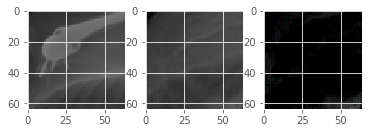

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


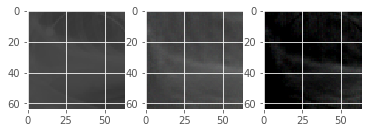

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


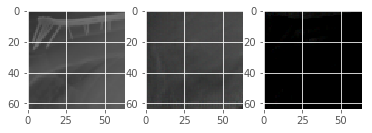

In [42]:
for i in range(3):
    plt.subplot(131)
    plt.imshow(denorm(val_images[i]).transpose(0,2))
    plt.subplot(132)
    plt.imshow(denorm(re_images[i]).transpose(0,2))
    plt.subplot(133)
    plt.imshow(((re_images[i]-val_images[i])).transpose(0,2))
    plt.show()

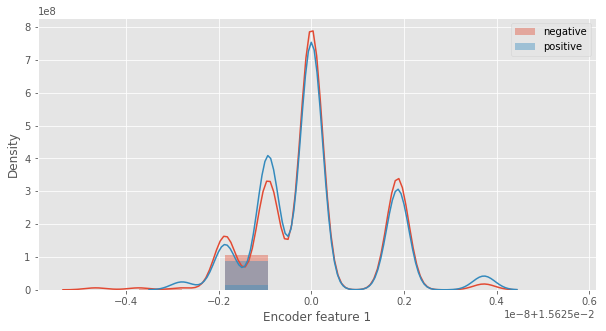

In [43]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
sns.distplot(le1[labels==0], hist=True, label='negative')
sns.distplot(le1[labels==1], hist=True, label='positive')
plt.xlabel('Encoder feature 1')
plt.ylabel('Density')
plt.legend()

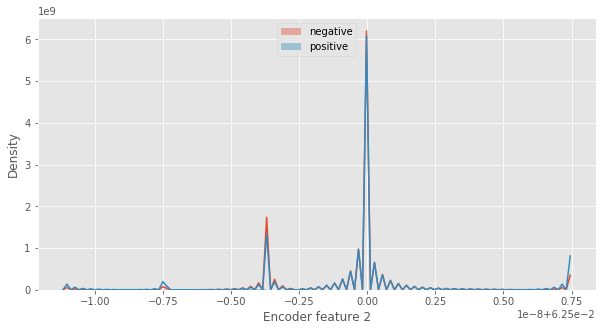

In [55]:
plt.figure(figsize=(10, 5))
sns.distplot(le2[labels==0].clip(min=-1, max=0.75), hist=True, label='negative')
sns.distplot(le2[labels==1].clip(min=-1, max=0.75), hist=True, label='positive')
plt.xlabel('Encoder feature 2')
plt.ylabel('Density')
plt.legend()

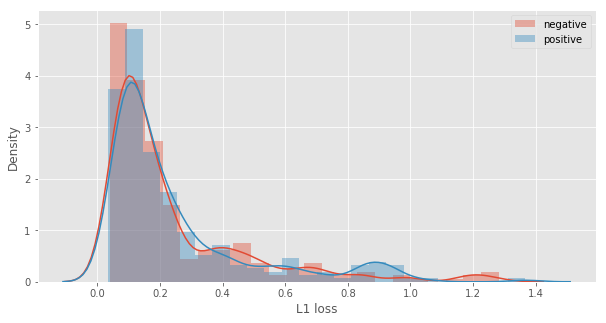

In [45]:
plt.figure(figsize=(10, 5))
sns.distplot(l1[labels==0], hist=True, label='negative')
sns.distplot(l1[labels==1], hist=True, label='positive')
plt.xlabel('L1 loss')
plt.ylabel('Density')
plt.legend()

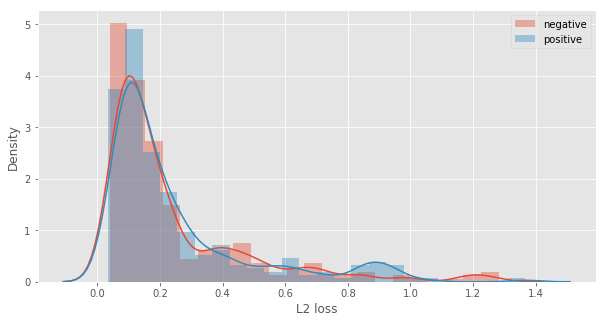

In [46]:
plt.figure(figsize=(10, 5))
sns.distplot(l2[labels==0], hist=True, label='negative')
sns.distplot(l2[labels==1], hist=True, label='positive')
plt.xlabel('L2 loss')
plt.ylabel('Density')
plt.legend()

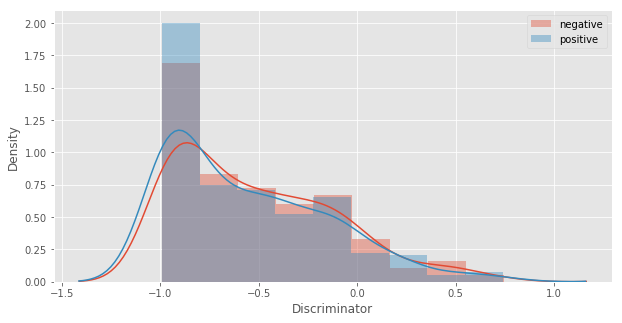

In [47]:
plt.figure(figsize=(10, 5))
sns.distplot(ld[labels==0], hist=True, label='negative')
sns.distplot(ld[labels==1], hist=True, label='positive')
plt.xlabel('Discriminator')
plt.ylabel('Density')
plt.legend()

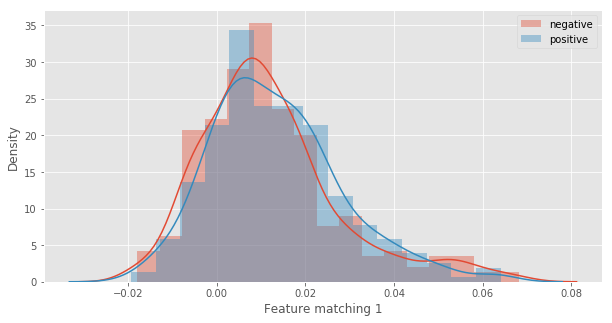

In [48]:
plt.figure(figsize=(10, 5))
sns.distplot(ld4[labels==0], hist=True, label='negative')
sns.distplot(ld4[labels==1], hist=True, label='positive')
plt.xlabel('Feature matching 1')
plt.ylabel('Density')
plt.legend()

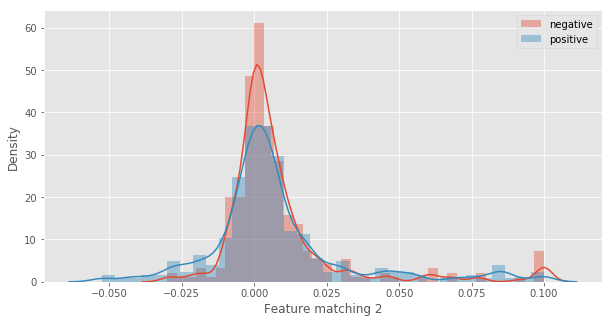

In [51]:
plt.figure(figsize=(10, 5))
sns.distplot(ld3[labels==0].clip(min=None, max=0.10), hist=True, label='negative')
sns.distplot(ld3[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('Feature matching 2')
plt.ylabel('Density')
plt.legend()

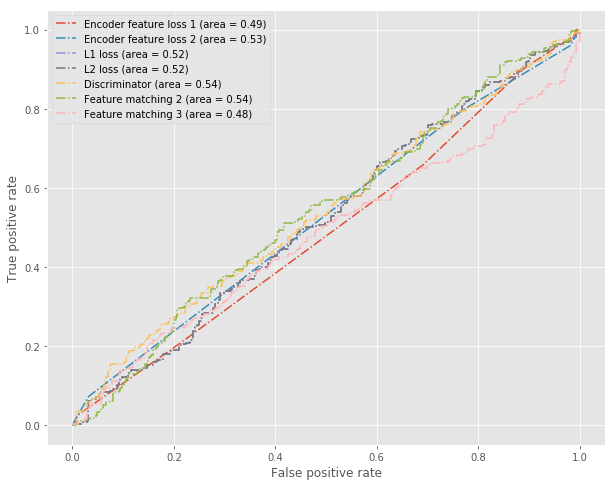

In [50]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresh = roc_curve(labels, le1)
auc = roc_auc_score(labels, le1)
plt.plot(fpr, tpr, '-.', label=f'Encoder feature loss 1 (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, le2)
auc = roc_auc_score(labels, le2)
plt.plot(fpr, tpr, '-.', label=f'Encoder feature loss 2 (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, l1)
auc = roc_auc_score(labels, l1)
plt.plot(fpr, tpr, '-.', label=f'L1 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, l2)
auc = roc_auc_score(labels, l2)
plt.plot(fpr, tpr, '-.', label=f'L2 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, -ld)
auc = roc_auc_score(labels, -ld)
plt.plot(fpr, tpr, '-.', label=f'Discriminator (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, ld4)
auc = roc_auc_score(labels, ld4)
plt.plot(fpr, tpr, '-.', label=f'Feature matching 2 (area = {auc:.2f})')
                    
fpr, tpr, thresh = roc_curve(labels, ld3)
auc = roc_auc_score(labels, ld3)
plt.plot(fpr, tpr, '-.', label=f'Feature matching 3 (area = {auc:.2f})')
                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()